In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[-1])

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false'
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *

In [2]:
#u_data = jnp.load("darcy_example_data/u_vals.npy")
x_grid=jnp.linspace(0,1,100)
y_grid=jnp.linspace(0,1,100)
X,Y=jnp.meshgrid(x_grid,y_grid)

@jit
def u_true_function1(x1,x2):
    return jnp.exp(jnp.sin(1*(jnp.cos(2*x1) + jnp.cos(3*x2))))
def u_true_function2(x1,x2):
    return jnp.exp(0.2 * (jnp.sin(1*(jnp.cos(5*x1) - jnp.cos(4*x2)))))

def u_true_function3(x1,x2):
    return jnp.sin(2 * x1) * jnp.cos(3 * x2)

def A(x1,x2):
    return jnp.exp(jnp.sin(jnp.cos(x1) + jnp.cos(x2)))
    #return 2.

def A_times_grad_u1(x1,x2):
    grad_u = jacfwd(u_true_function1, argnums=[0,1])
    return A(x1,x2)*jnp.array(grad_u(x1,x2))
def A_times_grad_u2(x1,x2):
    grad_u = jacfwd(u_true_function2, argnums=[0,1])
    return A(x1,x2)*jnp.array(grad_u(x1,x2))
def A_times_grad_u3(x1,x2):
    grad_u = jacfwd(u_true_function3, argnums=[0,1])
    return A(x1,x2)*jnp.array(grad_u(x1,x2))

def rhs1(x1,x2):
    div = jacfwd(A_times_grad_u1, argnums=[0,1])
    return -jnp.trace(jnp.array(div(x1,x2)))
def eval_rhs1(pairs):
    return jnp.array(vmap(lambda t: rhs1(t[0], t[1]))(pairs))

def rhs2(x1,x2):
    div = jacfwd(A_times_grad_u2, argnums=[0,1])
    return -jnp.trace(jnp.array(div(x1,x2)))
def eval_rhs2(pairs):
    return jnp.array(vmap(lambda t: rhs2(t[0], t[1]))(pairs))

def rhs3(x1,x2):
    div = jacfwd(A_times_grad_u3, argnums=[0,1])
    return -jnp.trace(jnp.array(div(x1,x2)))
@jax.jit
def eval_rhs3(pairs):
    return jnp.array(vmap(lambda t: rhs3(t[0], t[1]))(pairs))

In [3]:
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)


    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [38]:
num_grid_points = 12
# Ghost grid - Same per function
xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
xy_all = jnp.vstack([xy_bdy,xy_int])


u_true1 = u_true_function1(xy_all[:,0],xy_all[:,1])
u_true2 = u_true_function2(xy_all[:,0],xy_all[:,1])
u_true3 = u_true_function3(xy_all[:,0],xy_all[:,1])


num_obs1 = 2
np.random.seed(20)
x_y_sample_inds1 = np.random.choice(list(np.arange(len(xy_int))),num_obs1,replace = False)
x_y_sample_inds1 = jnp.hstack([x_y_sample_inds1])
xy_obs1 = jnp.vstack([xy_bdy,xy_int[x_y_sample_inds1]])
u_obs1 = u_true_function1(xy_obs1[:,0],xy_obs1[:,1])

xy_f1 = xy_int[jnp.hstack([np.random.choice(list(np.arange(len(xy_int))),num_obs1,replace = False)])]
f_obs1 = eval_rhs1(xy_f1)

num_obs2 = 2
np.random.seed(21)
x_y_sample_inds2 = np.random.choice(list(np.arange(len(xy_int))),num_obs2,replace = False)
x_y_sample_inds2 = jnp.hstack([x_y_sample_inds2])
xy_obs2 = jnp.vstack([xy_bdy,xy_int[x_y_sample_inds2]])
u_obs2 = u_true_function2(xy_obs2[:,0],xy_obs2[:,1])

xy_f2 = xy_int[jnp.hstack([np.random.choice(list(np.arange(len(xy_int))),num_obs2,replace = False)])]
f_obs2 = eval_rhs1(xy_f2)


num_obs3 = 2
np.random.seed(22)
x_y_sample_inds3 = np.random.choice(list(np.arange(len(xy_int))),num_obs3,replace = False)
x_y_sample_inds3 = jnp.hstack([x_y_sample_inds3])
xy_obs3 = jnp.vstack([xy_bdy,xy_int[x_y_sample_inds3]])
u_obs3 = u_true_function3(xy_obs3[:,0],xy_obs3[:,1])

xy_f3 = xy_int[jnp.hstack([np.random.choice(list(np.arange(len(xy_int))),num_obs3,replace = False)])]
f_obs3 = eval_rhs1(xy_f3)


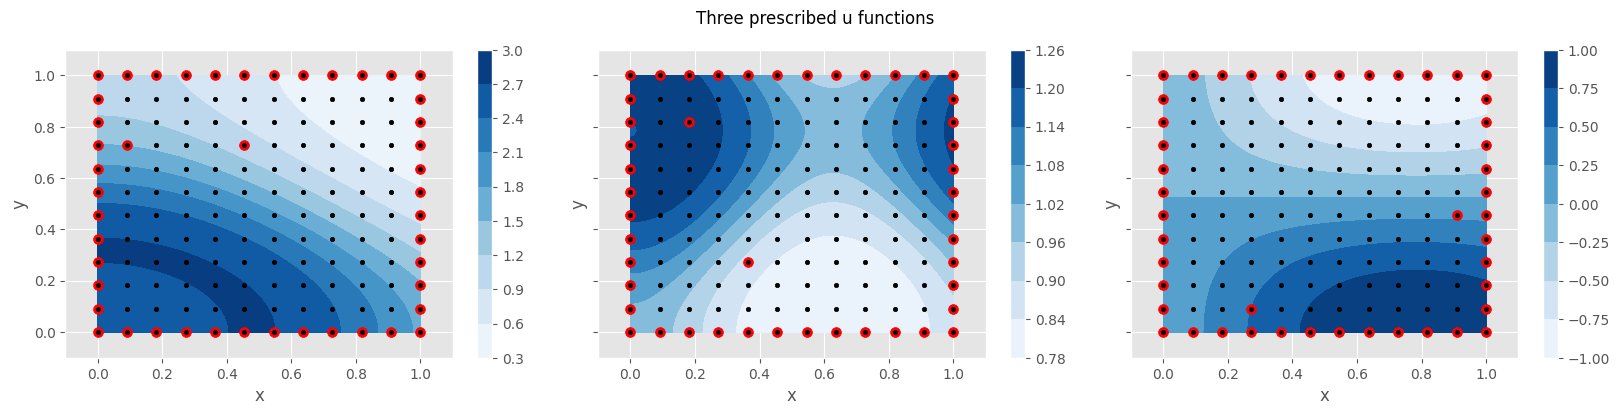

In [39]:
# Plot u's
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T


fig, axs = plt.subplots(figsize = (20,4), nrows =1 , ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Three prescribed u functions')
axs0 = axs[0].tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function1(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar(axs0, ax = axs[0])
axs[0].scatter(xy_obs1[:,0],xy_obs1[:,1],c='red', s = 50)
axs[0].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim(-0.1,1.1)
axs[0].set_ylim(-0.1,1.1)
axs1 = axs[1].tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function2(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar(axs1, ax = axs[1])
axs[1].scatter(xy_obs2[:,0],xy_obs2[:,1],c='red', s = 50)
axs[1].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xlim(-0.1,1.1)
axs[1].set_ylim(-0.1,1.1)
axs2 = axs[2].tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function3(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar(axs2, ax = axs[2])
axs[2].scatter(xy_obs3[:,0],xy_obs3[:,1],c='red', s = 50)
axs[2].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_xlim(-0.1,1.1)
axs[2].set_ylim(-0.1,1.1)
plt.show()

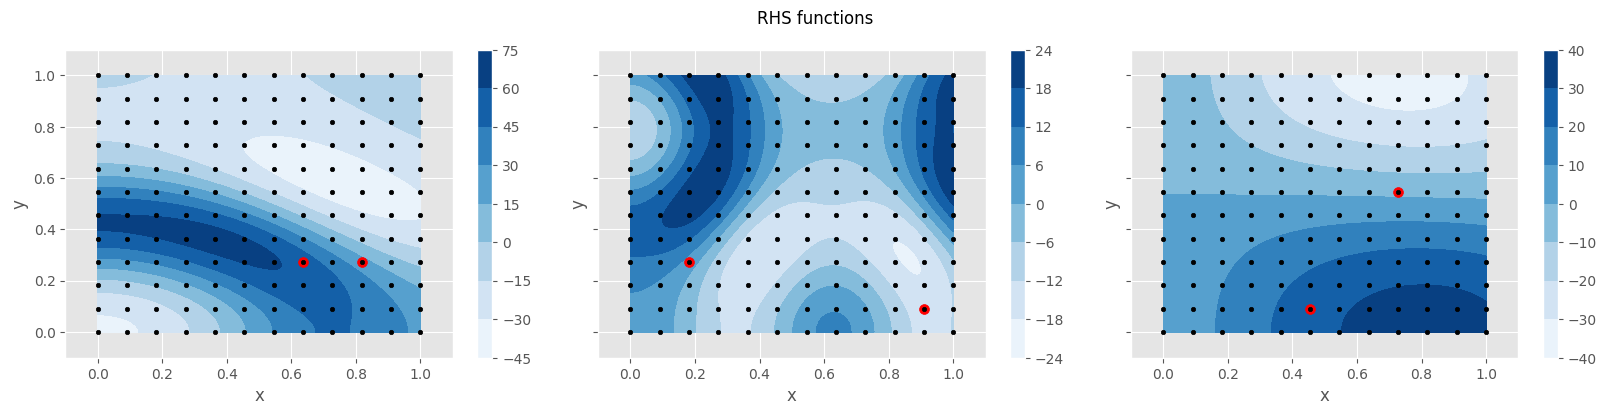

In [40]:
fig, axs = plt.subplots(figsize = (20,4), nrows =1 , ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('RHS functions')

rhs_funcs = tuple([eval_rhs1,eval_rhs2,eval_rhs3])
f_obs_locations =tuple([
    xy_f1,xy_f2,xy_f3
])
contour_plots = []
for i in range(3):
    ax_plot = axs[i]
    obs_locations = f_obs_locations[i]
    contour_plots.append(ax_plot.tricontourf(xy_fine[:,0],xy_fine[:,1],rhs_funcs[i](xy_fine),cmap = 'Blues'))
    plt.colorbar(contour_plots[i], ax = ax_plot)
    ax_plot.scatter(obs_locations[:,0],obs_locations[:,1],c='red', s = 50)
    ax_plot.scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
    ax_plot.set_xlabel('x')
    ax_plot.set_ylabel('y')
    ax_plot.set_xlim(-0.1,1.1)
    ax_plot.set_ylim(-0.1,1.1)


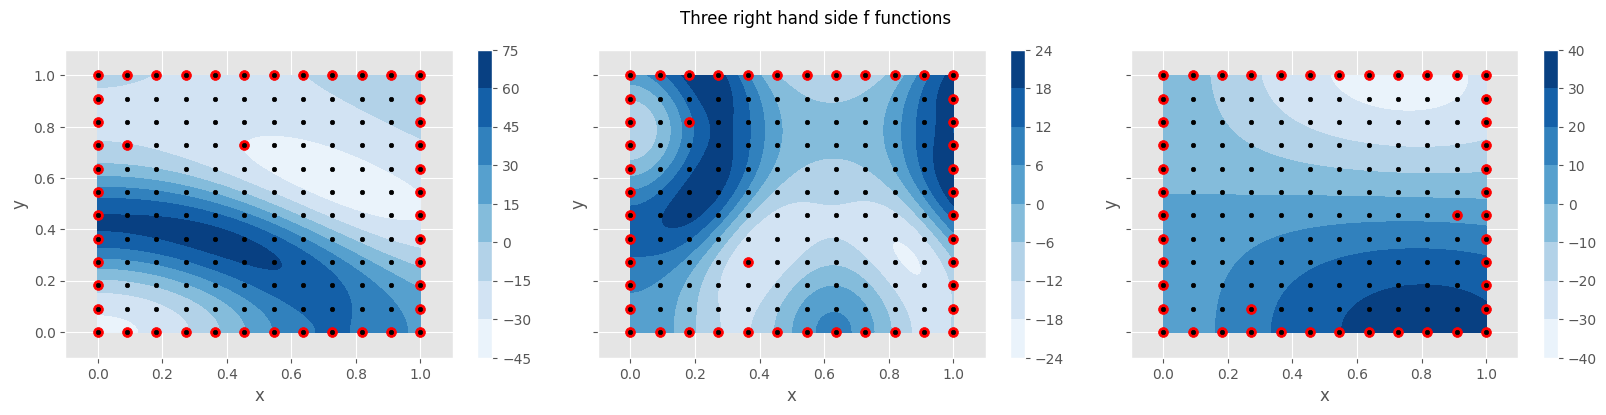

In [41]:
# Plot f's
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

fig, axs = plt.subplots(figsize = (20,4), nrows =1 , ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Three right hand side f functions')
axs0 = axs[0].tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs1(xy_fine),cmap = 'Blues')
plt.colorbar(axs0, ax = axs[0])
axs[0].scatter(xy_obs1[:,0],xy_obs1[:,1],c='red', s = 50)
axs[0].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim(-0.1,1.1)
axs[0].set_ylim(-0.1,1.1)
axs1 = axs[1].tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs2(xy_fine),cmap = 'Blues')
plt.colorbar(axs1, ax = axs[1])
axs[1].scatter(xy_obs2[:,0],xy_obs2[:,1],c='red', s = 50)
axs[1].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xlim(-0.1,1.1)
axs[1].set_ylim(-0.1,1.1)
axs2 = axs[2].tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs3(xy_fine),cmap = 'Blues')
plt.colorbar(axs2, ax = axs[2])
axs[2].scatter(xy_obs3[:,0],xy_obs3[:,1],c='red', s = 50)
axs[2].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_xlim(-0.1,1.1)
axs[2].set_ylim(-0.1,1.1)
plt.show()

In [42]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])


k_u = get_gaussianRBF(0.25)


u_models = tuple([InducedRKHS(
    xy_all,
    feature_operators,
    k_u
    ) for i in range(3)])
rhs_functions = tuple([eval_rhs1,eval_rhs2,eval_rhs3])


observation_points = (xy_obs1, xy_obs2, xy_obs3)
observation_values = (u_obs1, u_obs2, u_obs3)
collocation_points = (xy_int,)*3
rhs_values = tuple(rhs_func(xy_int) for rhs_func in rhs_functions)


k_f = get_gaussianRBF(0.25)

rhs_models = tuple([InducedRKHS(
    xy_all,
    tuple([eval_k]),
    k_f
    ) for i in range(3)])

rhs_funcs = tuple([eval_rhs1,eval_rhs2,eval_rhs3])
rhs_obs_locations =tuple([
    xy_f1,xy_f2,xy_f3
])

rhs_obs_values = tuple([
    rhs(xy) for rhs,xy in zip(rhs_funcs,rhs_obs_locations)
])

rhs_params_init = tuple([
    model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(
        rhs_obs_locations,rhs_obs_values,rhs_models)])

all_u_params_init = tuple([
    model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(
        observation_points,observation_values,u_models)])

grid_features_u_init = jnp.vstack([(model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model,model_params in zip(u_models,all_u_params_init) ])


k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
k_P_x_part = get_gaussianRBF(0.4)
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
 

class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )
    num_params = len(grid_features_u_init)

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params

In [43]:
class RHSOperatorPDEModel():
    def __init__(
        self,
        operator_model,
        u_models:tuple,
        observation_points:tuple,
        observation_values:tuple,
        collocation_points:tuple,
        feature_operators:tuple,
        rhs_models:tuple,
        rhs_obs_locations:tuple,
        rhs_values:tuple,
        rhs_forcing_values:Optional[tuple]=None,
        rhs_operator=None,
        datafit_weight = 10,
    ):
        if rhs_forcing_values is None:
            rhs_forcing_values = tuple(jnp.zeros(len(col_points)) for col_points in collocation_points)
        check_OperatorPDEModel(u_models,observation_points,observation_values,collocation_points,rhs_forcing_values)
        self.u_models = u_models
        self.operator_model = operator_model
        self.observation_points = observation_points
        self.observation_values = observation_values
        self.collocation_points = collocation_points
        self.rhs_forcing_values = rhs_forcing_values
        self.feature_operators = feature_operators
        self.datafit_weight = datafit_weight

        self.rhs_operator = rhs_operator

        self.stacked_observation_values = jnp.hstack(observation_values)
        self.stacked_collocation_rhs = jnp.hstack(rhs_forcing_values)
        

        self.rhs_models = rhs_models
        self.stacked_rhs_fit = jnp.hstack(rhs_values)
        self.rhs_obs_locations = rhs_obs_locations
        #Precompute parameter indices to pull out different parameter blocks
        self.total_parameters = sum([model.num_params for model in u_models]) + self.operator_model.num_params
        
        #Assume we put the parameters for the operators at the start of the flattened parameter set
        self.operator_model_indices = jnp.arange(
            self.total_parameters - self.operator_model.num_params,self.total_parameters
            )

        #Compute the start and end indices of the parameter sets for u_models
        u_param_inds = jnp.cumsum(jnp.array([0]+[model.num_params for model in u_models]))
        self.u_indexing = [
            jnp.arange(p,q) for p,q in zip(u_param_inds[:-1],u_param_inds[1:])
        ]

        rhs_param_inds = jnp.cumsum(jnp.array([self.total_parameters]+[model.num_params for model in rhs_models]))
        self.rhs_indexing = [
            jnp.arange(p,q) for p,q in zip(rhs_param_inds[:-1],rhs_param_inds[1:])
        ]

    def get_P_params(self,all_params):
        return all_params[self.operator_model_indices]
    
    def get_u_params(self,all_params):
        return [all_params[ind_set] for ind_set in self.u_indexing]

    def get_rhs_params(self,all_params):
        return [all_params[ind_set] for ind_set in self.rhs_indexing]

    @partial(jit, static_argnames=['self','u_model'])
    def get_single_eqn_features(
        self,
        u_model, 
        u_params,
        evaluation_points,
        ):
        num_points = len(evaluation_points)
        num_ops = len(self.feature_operators)
        op_evaluation = u_model.evaluate_operators(self.feature_operators,evaluation_points,u_params)
        u_op_features = op_evaluation.reshape(num_points,num_ops,order = 'F')
        full_features = jnp.hstack([evaluation_points,u_op_features])
        return full_features
    
    @partial(jit, static_argnames=['self'])
    def get_stacked_eqn_features(
        self,
        all_u_params
    ):
        return jnp.vstack([
            self.get_single_eqn_features(u_model,u_params,eval_points) 
            for u_model,u_params,eval_points in zip(
                self.u_models,
                all_u_params,
                self.collocation_points
            )
        ])
    
    @partial(jit, static_argnames=['self','u_model'])
    def get_rhs_op_single(self,u_model,u_params,evaluation_points):
        if self.rhs_operator is None:
            return jnp.zeros(len(evaluation_points))
        else:
            op_evaluation = u_model.evaluate_operators((self.rhs_operator,),evaluation_points,u_params)
            return op_evaluation.flatten()
        
    @partial(jit, static_argnames=['self'])
    def get_stacked_rhs_op(
        self,
        all_u_params
    ):
        return jnp.hstack([
            self.get_rhs_op_single(u_model,u_params,eval_points) 
            for u_model,u_params,eval_points in zip(
                self.u_models,
                all_u_params,
                self.collocation_points
            )
        ])
    
    def get_overall_rhs(self,all_rhs_params):
        return jnp.hstack(
            [
                model.point_evaluate(eval_points,rhs_params) for model,eval_points,rhs_params in zip(
                    self.rhs_models,self.collocation_points,all_rhs_params)
                ]
                )
    
    @partial(jit, static_argnames=['self'])
    def equation_residual(self,full_params):
        """
        In the future, we may want to break this up, calculating residuals before stacking so we can look at errors on each function individually
        """
        all_u_params = self.get_u_params(full_params)
        P_params = self.get_P_params(full_params)
        stacked_features = self.get_stacked_eqn_features(all_u_params=all_u_params)
        P_preds = self.operator_model.predict(stacked_features,P_params)
        all_rhs_params = self.get_rhs_params(full_params)
        overall_rhs = self.get_overall_rhs(all_rhs_params)
    
        return (overall_rhs - P_preds)


    @partial(jit, static_argnames=['self'])
    def datafit_residual(self,full_params):
        all_u_params = self.get_u_params(full_params)
        obs_preds = jnp.hstack(
            [
                model.point_evaluate(obs_points,u_params) 
                for model,obs_points,u_params in zip(
                    self.u_models,
                    self.observation_points,
                    all_u_params)
                ])
        residuals = self.stacked_observation_values - obs_preds
        rhs_obs_vals = jnp.hstack(
            [
                model.point_evaluate(eval_points,rhs_params) for model,eval_points,rhs_params in zip(
                    self.rhs_models,self.rhs_obs_locations,self.get_rhs_params(full_params))
                ]
                )
        residuals_rhs = self.stacked_rhs_fit - rhs_obs_vals
        return jnp.hstack([residuals,residuals_rhs])
    
    @partial(jit, static_argnames=['self'])
    def F(self,full_params):
        eqn_res = self.equation_residual(full_params)
        data_res = self.datafit_residual(full_params)
        return jnp.hstack([
            jnp.sqrt(self.datafit_weight) * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    #usually jacrev is faster than jacfwd on examples I've tested
    jac = jit(jacrev(F,argnums = 1),static_argnames='self')

    @partial(jit, static_argnames=['self'])
    def loss(self,full_params):
        """
        TODO: Include the regularization term here instead of in EqnModel"""
        return (1/2) * jnp.linalg.norm(self.F(full_params))**2
    
    @partial(jit, static_argnames=['self'])
    def damping_matrix(self,full_params,nugget = 1e-3):
        """
        Presumably, I shouldn't build the kernel matrix for P again, but that would make the code
        more unwieldy
        """
        u_params = self.get_u_params(full_params)
        grid_feats = self.get_stacked_eqn_features(u_params)
        kmat_P = self.operator_model.kernel_function(grid_feats,grid_feats)
        dmat = block_diag(
            *([model.kmat for model in self.u_models]+[kmat_P] + [model.kmat for model in self.rhs_models])
            )
        dmat= dmat + nugget*diagpart(dmat)
        return dmat

In [44]:
collocation_points = tuple([xy_int]*3)
EqnModel  = RHSOperatorPDEModel(
    P_model,
    u_models,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_models,
    rhs_obs_locations,
    rhs_obs_values,
    datafit_weight = 5.,
)

In [45]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack(
    list(all_u_params_init)+
    [jnp.zeros(3*len(xy_int))] + 
    list(rhs_params_init)
    )

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-10,
    max_iter = 201,
    init_alpha=3,
    line_search_increase_ratio=2.
)

  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 77.05, Jres = 198.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 21.05, Jres = 3.949e+03, alpha = 4.167, improvement_ratio = 0.9893
Iteration 2, loss = 2.067, Jres = 7.98e+03, alpha = 3.472, improvement_ratio = 0.9773
Iteration 3, loss = 0.9619, Jres = 767.7, alpha = 2.894, improvement_ratio = 1.004
Iteration 4, loss = 0.6039, Jres = 128.3, alpha = 2.411, improvement_ratio = 1.018
Iteration 5, loss = 0.443, Jres = 62.78, alpha = 2.009, improvement_ratio = 1.016
Iteration 50, loss = 0.001036, Jres = 6.781, alpha = 0.001641, improvement_ratio = 0.8298
Iteration 100, loss = 2.543e-05, Jres = 1.416, alpha = 0.000318, improvement_ratio = 0.7316
Iteration 150, loss = 8.634e-06, Jres = 0.2211, alpha = 0.000318, improvement_ratio = 0.302
Line Search Failed!
Final Iteration Results
Iteration 177, loss = 6.727e-06, Jres = 0.04341, alpha = 995.5


In [46]:
# hess_loss = jit(jax.hessian(EqnModel.loss))
# gradloss = jit(jax.grad(EqnModel.loss))

#H = hess_loss(params)
#g = gradloss(params)

#analyze_hessian(H,g)

  0%|          | 0/500 [00:00<?, ?it/s]

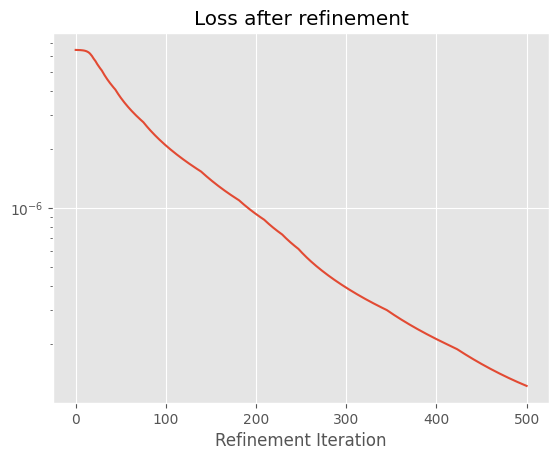

In [47]:
from LM_Solve import adaptive_refine_solution

p_adjusted,refinement_losses,reg_sequence = adaptive_refine_solution(params,EqnModel,1.,500)

plt.plot(refinement_losses)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')

In [48]:
#analyze_hessian(hess_loss(p_adjusted),gradloss(p_adjusted))

In [49]:
u_sols = EqnModel.get_u_params(p_adjusted)
P_sol = EqnModel.get_P_params(p_adjusted)

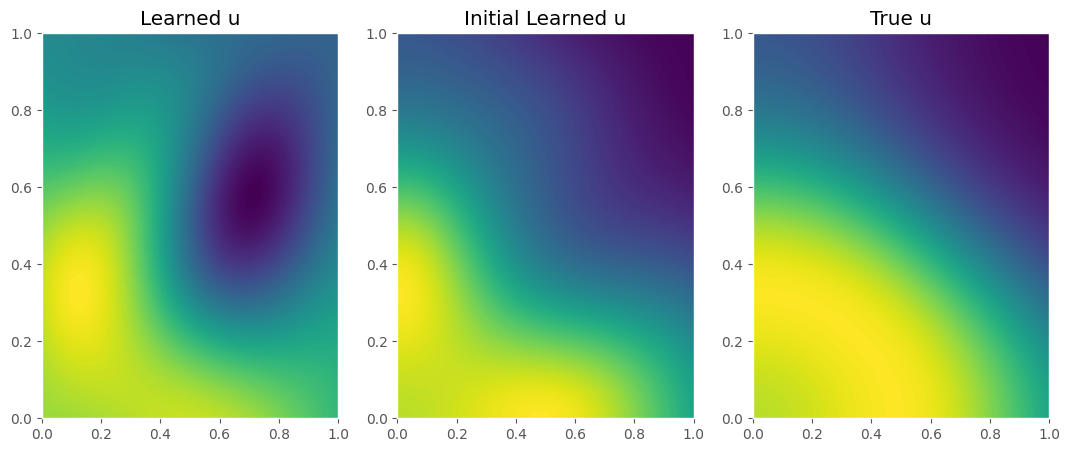

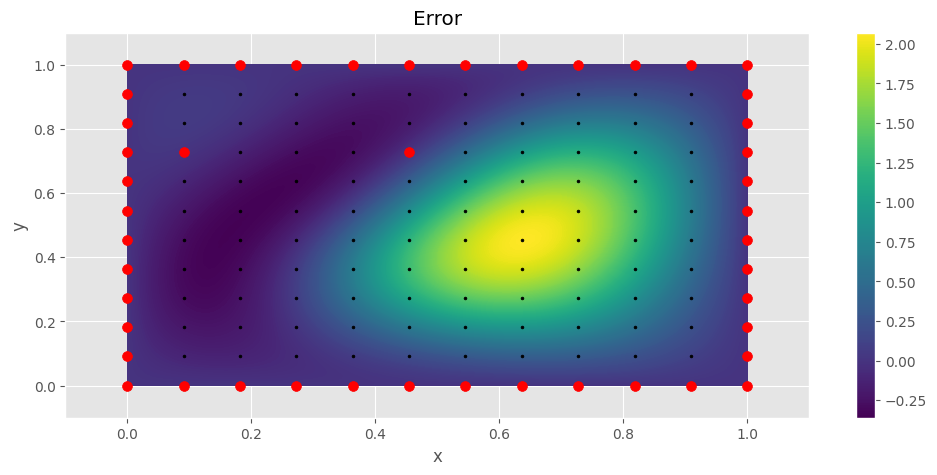

In [50]:
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_grid_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T


u_eval_fine =u_models[0].point_evaluate(xy_grid_fine,u_sols[0])
u_eval_fine_init = u_models[0].point_evaluate(xy_grid_fine,all_u_params_init[0])

u_true_fine = u_true_function1(xy_grid_fine[:,0],xy_grid_fine[:,1])
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_eval_fine,200)

plt.subplot(1,3,2)
plt.title("Initial Learned u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_eval_fine_init,200)

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_true_fine,200)
plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(xy_all[:,0],xy_all[:,1],c='black',s = 4)
plt.scatter(xy_obs1[:,0],xy_obs1[:,1],c='red',s = 50)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [51]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

u_true_functions = [u_true_function1,u_true_function2,u_true_function3]
for i in range(3):
    model = u_models[i]
    sol = u_sols[i]
    init_params = all_u_params_init[i]
    u_eval_fine =model.point_evaluate(xy_grid_fine,sol)
    u_eval_fine_init = model.point_evaluate(xy_grid_fine,init_params)

    u_true_fine = u_true_functions[i](xy_grid_fine[:,0],xy_grid_fine[:,1])

    print(f"Results on function {i}")
    print("Optimized model: ",get_nrmse(u_true_fine,u_eval_fine))
    print("Two Step model: ",get_nrmse(u_true_fine,u_eval_fine_init))

Results on function 0
Optimized model:  0.4012231124222297
Two Step model:  0.15916395240032308
Results on function 1
Optimized model:  0.19568662001940698
Two Step model:  0.09262975263528149
Results on function 2
Optimized model:  0.9742903563772614
Two Step model:  0.04939841888932041


In [52]:
u1_model = u_models[0]
u1_sol = u_sols[0]

num_fine_grid = 50
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

u_true_interior = u_true_function1(xy_fine_int[:,0],xy_fine_int[:,1])

model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)

model_fine_features_u = u1_model.evaluate_operators(
    feature_operators,xy_fine_int,u1_sol
).reshape(len(xy_fine_int),len(feature_operators),order = 'F')

evaluation_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,u1_sol)
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
model_fine_features = jnp.hstack([xy_fine_int,grid_features_u])

P_preds_model_features = P_model.kernel_function(model_fine_features,model_grid_features_all)@P_sol




init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
K = P_model.kernel_function(init_P_features,init_P_features)
P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_overall_rhs(rhs_params_init))

init_fine_features_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,all_u_params_init[0]).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
evaluation_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,u1_sol)
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
init_fine_features = jnp.hstack([xy_fine_int,grid_features_u])
P_preds_init_model_features_init = P_model.kernel_function(init_fine_features,init_P_features)@P_params_naive

In [53]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

print("Optimized model feature predictions ",get_nrmse(eval_rhs1(xy_fine_int),P_preds_model_features))
print("2 Step model feature predictions ",get_nrmse(eval_rhs1(xy_fine_int),P_preds_init_model_features_init))

Optimized model feature predictions  0.8517572227428564
2 Step model feature predictions  0.7065314210963869


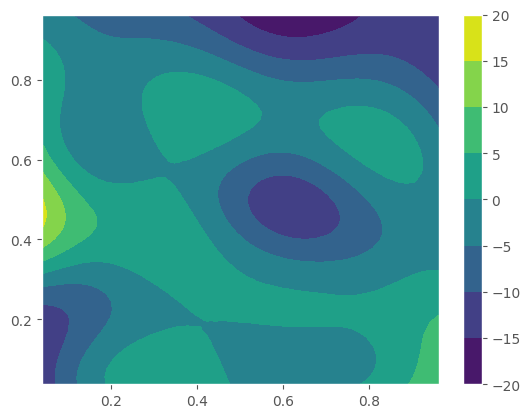

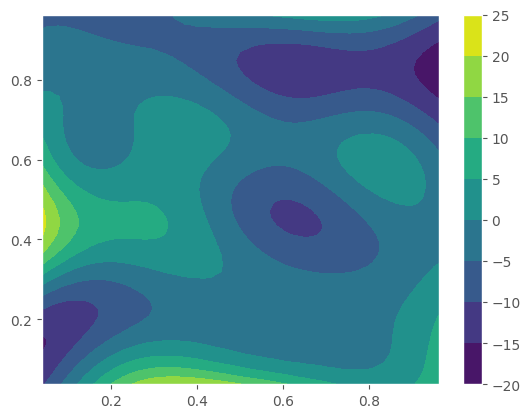

In [94]:
plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],eval_rhs1(xy_fine_int)-P_preds_model_features)
plt.colorbar()
plt.show()
plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],eval_rhs1(xy_fine_int)-P_preds_init_model_features_init)
plt.colorbar()
plt.show()

In [98]:
rhs_values = [
                model.point_evaluate(xy_fine_int,rhs_params) for model,rhs_params in zip(
                    rhs_models,EqnModel.get_rhs_params(p_adjusted))
                ]

rhs_values_init = [
                model.point_evaluate(xy_fine_int,rhs_params) for model,rhs_params in zip(
                    rhs_models,rhs_params_init)
                ]

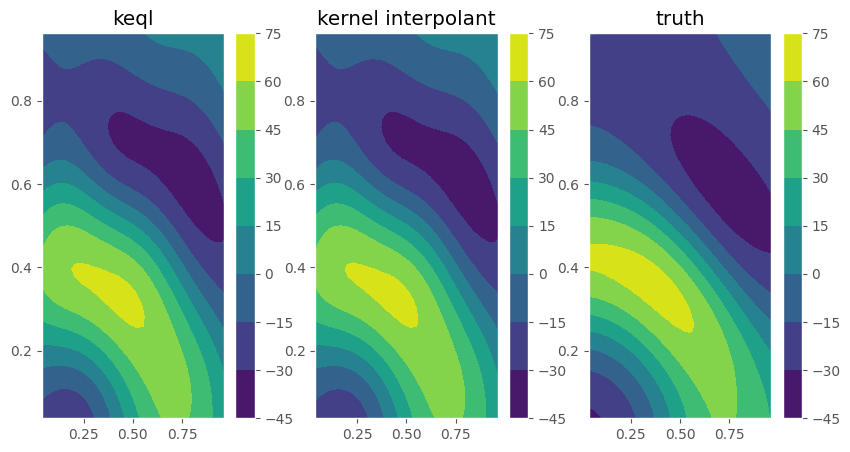

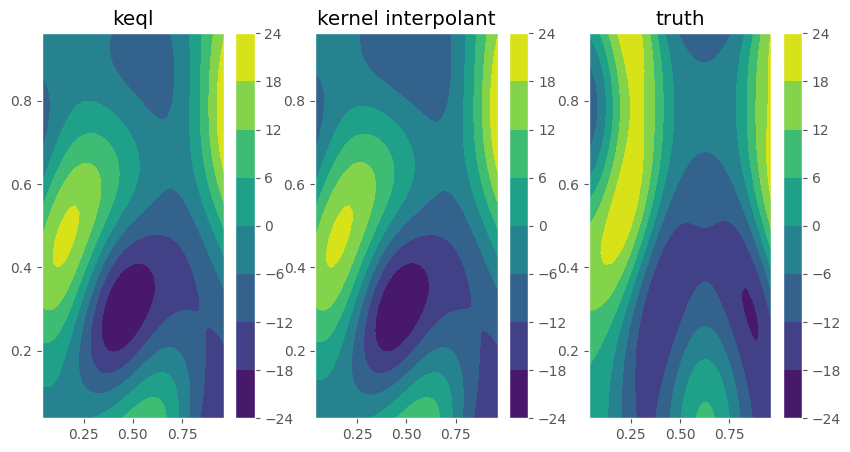

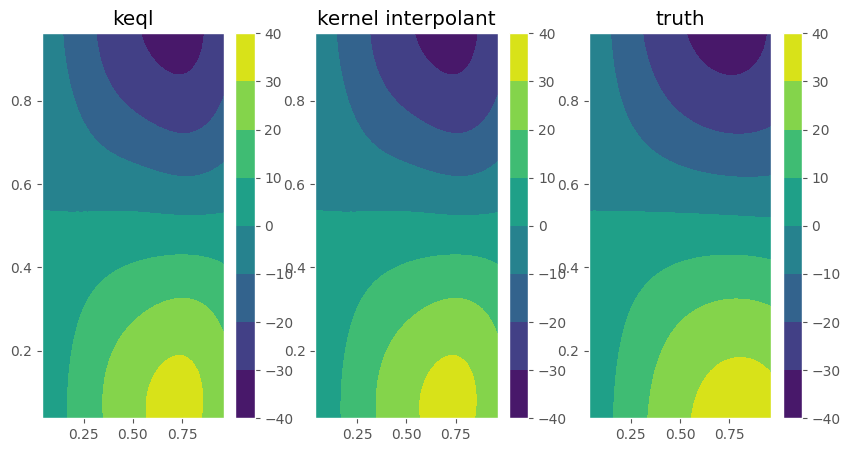

In [100]:
for i in range(3):
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],rhs_values[i])
    plt.colorbar()
    plt.title("keql")
    
    plt.subplot(1,3,2)
    plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],rhs_values_init[i])
    plt.colorbar()
    plt.title("kernel interpolant")

    plt.subplot(1,3,3)
    plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],rhs_funcs[i](xy_fine_int))
    plt.colorbar()
    plt.title('truth')
    plt.show()
